In [26]:
pip install iplot

ERROR: Could not find a version that satisfies the requirement iplot (from versions: none)
ERROR: No matching distribution found for iplot


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [6]:
# Assuming train_df['target'] is your Series object
# You can create a bar chart using plotly
data = [
    go.Bar(
        x=train_df['target'].value_counts(normalize=True).index,
        y=train_df['target'].value_counts(normalize=True),
        marker=dict(color='red')
    )
]

layout = go.Layout(
    title='Distribution of the Target column in the training set',
    xaxis=dict(title='Target'),
    yaxis=dict(title='Percentage')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)
org_train_df=pd.read_csv('/content/ISIC_2020_Training_GroundTruth.csv')
train_dup=pd.read_csv('/content/ISIC_2020_Training_Duplicates.csv')
dup_list=train_dup['image_name_2'].tolist()
org_train_df=org_train_df[~org_train_df['image_name'].isin(dup_list)].reset_index(drop='True')

Ratio of Benign is to malignant in the Original dataset.As the Class imbalance is too high, We will introduce more malignant images from external data source for efficient training and avoid creating a biased model.

In [22]:
org_train_df.groupby(['benign_malignant']).count()['sex'].to_frame()

,sex
benign_malignant,
benign,32079
malignant,581


In [8]:
ext = pd.read_csv('/content/ext_train_concat.csv')

In [11]:
ext['benign_malignant'] = ext['target'].apply(lambda x: 'benign' if x == 0 else 'malignant')

In [12]:
ext.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,benign_malignant
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,benign
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,benign
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,benign
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,benign
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,benign
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,0,benign
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,0,benign
7,ISIC_0075663,IP_6017204,female,35.0,torso,0,benign
8,ISIC_0075914,IP_7622888,male,30.0,torso,0,benign
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,0,benign


In [13]:
ext_mal= ext[ext['target']==1]
train_mal = org_train_df[org_train_df['target']==1].drop(columns=['diagnosis'])
merged_df = pd.merge(ext_mal, train_mal, how='left', indicator=True)
ext_mal = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge']).reset_index(drop=True)

In [17]:
ext_mal['diagnosis']='unknown'

In [18]:
train_df = pd.concat([org_train_df, ext_mal], axis=0)

This is the ratio of number of  Malignent is to Benign images in the dataset after upsampling the Malignent Class. THe difference is still high.
Conclusion: Perform data Augmentation for efficient training.

In [23]:
train_df.groupby(['benign_malignant']).count()['sex'].to_frame()

,sex
benign_malignant,
benign,32079
malignant,5025


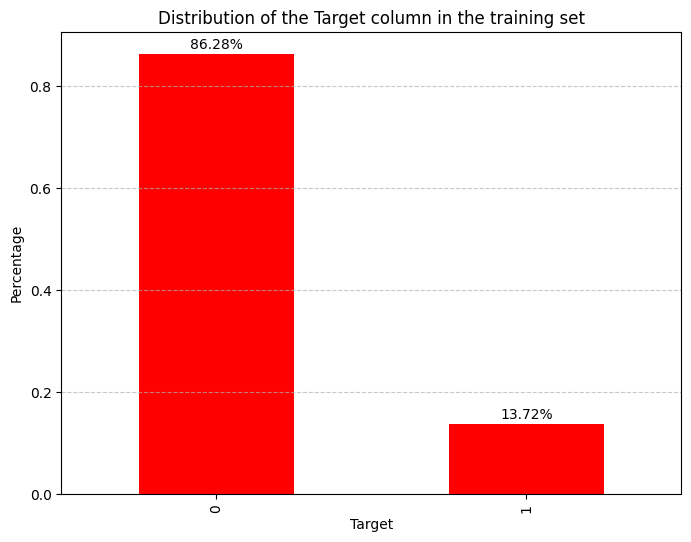

In [38]:
plt.figure(figsize=(8, 6))
counts = train_df['target'].value_counts(normalize=True)
ax = counts.plot(kind='bar', color='red')
plt.title('Distribution of the Target column in the training set')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding text annotations on top of each bar
for i in range(len(counts)):
    plt.text(i, counts[i] + 0.01, f'{counts[i]*100:.2f}%', ha='center')

plt.show()

<ipython-input-47-0f76a7414ade>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




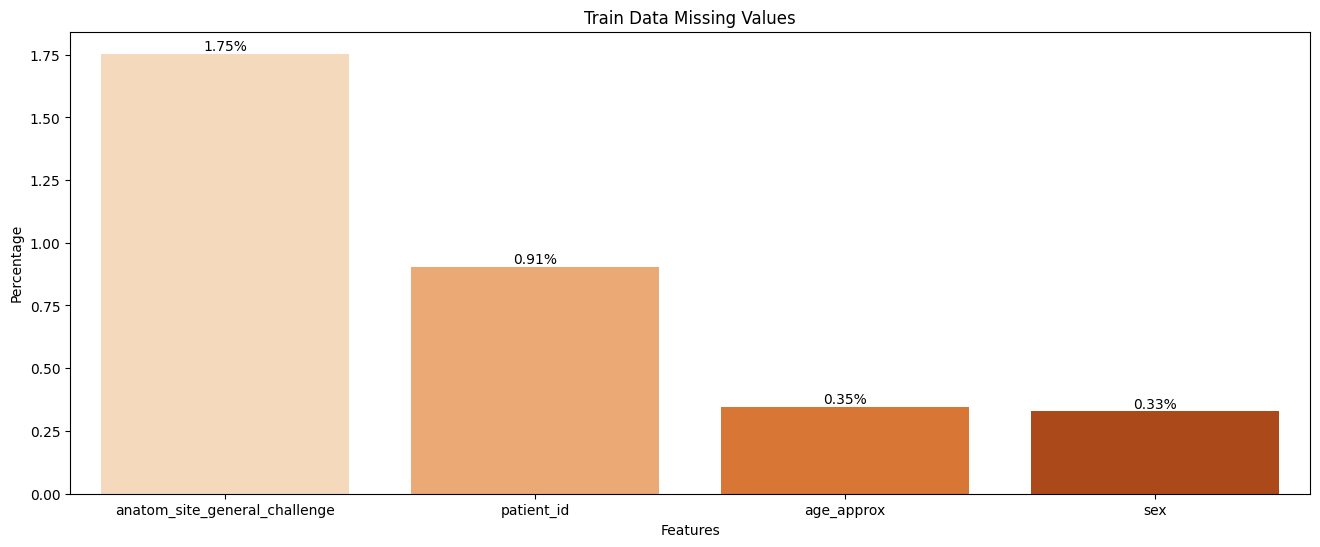

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) * 100)[(df.isnull().sum().sort_values(ascending=False) / len(df) * 100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_train = missing_percentage(train_df)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            ax=ax,
            palette='Oranges',  # You can specify a palette if needed
            )

ax.set_title('Train Data Missing Values')
ax.set_ylabel('Percentage')
ax.set_xlabel('Features')
#ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Adding annotations on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


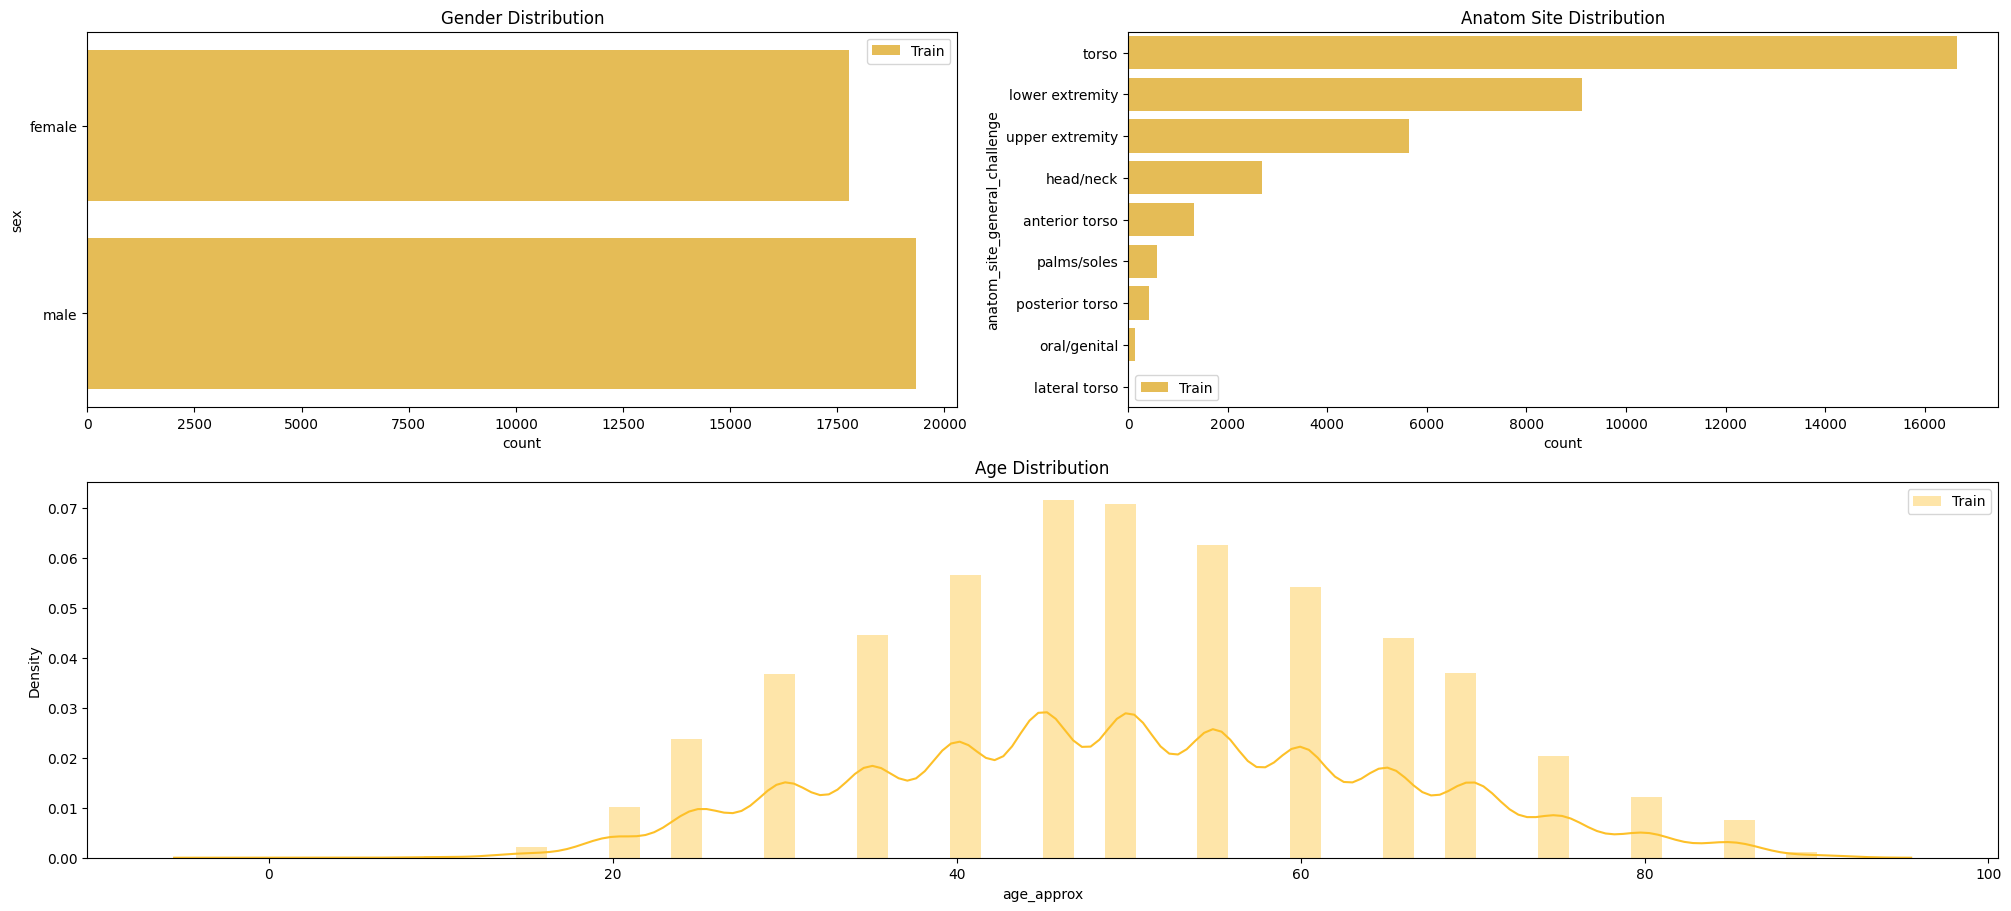

In [55]:
fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Gender Distribution
ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Gender Distribution')
sns.countplot(train_df.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
ax1.legend()

# Anatom Site Distribution
ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Anatom Site Distribution')
sns.countplot(train_df.anatom_site_general_challenge,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=train_df['anatom_site_general_challenge'].value_counts().index)
ax2.legend()

# Age Distribution
ax3 = fig.add_subplot(grid[1, :])
ax3.set_title('Age Distribution')
sns.distplot(train_df.age_approx, ax=ax3, label='Train', color='#fdc029')
ax3.legend()

plt.show()

In [56]:
for df in [train_df]:
    df['anatom_site_general_challenge'].fillna('unknown', inplace=True)

In [62]:
train_df['sex'].fillna(train_df['sex'].mode()[0], inplace=True)
train_df['patient_id'].fillna('unknown', inplace=True)
train_df['age_approx'].fillna(train_df['age_approx'].median(), inplace=True)

In [63]:
# Checking missing value counts:

print(
    f'Train missing value count: {train_df.isnull().sum().sum()}\n'
)

Train missing value count: 0



Exploring the Data:

Scans by Anatom Site

In [66]:
cntstr = train_df.anatom_site_general_challenge.value_counts().rename_axis('location').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['location'],
                 values='count',
                 color='count',
                 #color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Train Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

Body Part Ratio by Gender and Target:
Looks like some body parts are more likely to be malignant, head/neck comes first with followed by oral/genital and upper extremity. Scanned body part locations are similar in order between males and females with small differences on distribution.

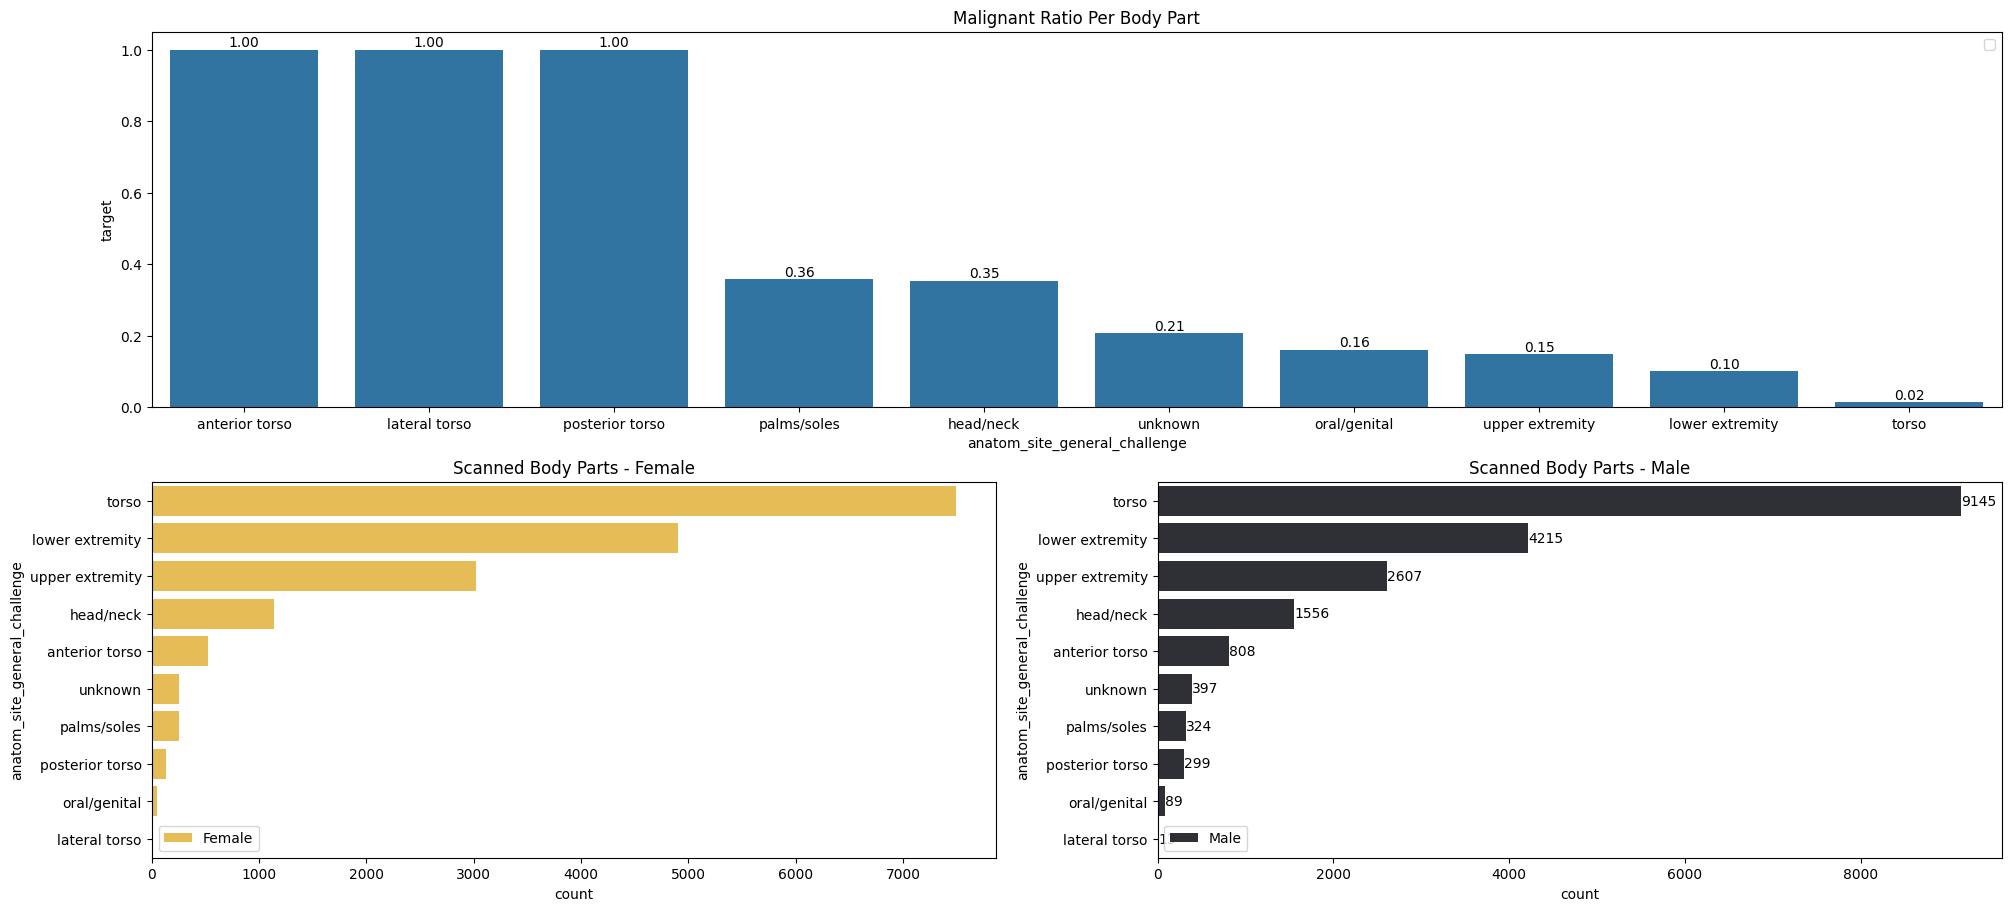

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.
ax1 = fig.add_subplot(grid[1, :2])
# Set the title.
ax1.set_title('Scanned Body Parts - Female')

# Plot:
sns.countplot(
    train_df[train_df['sex'] == 'female'].anatom_site_general_challenge.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
    color='#fdc029',
    label='Female',
    order=train_df['anatom_site_general_challenge'].value_counts().index)
ax1.legend()


# Customizing the second grid.
ax2 = fig.add_subplot(grid[1, 2:])
# Set the title.
ax2.set_title('Scanned Body Parts - Male')

# Plot.
sns.countplot(
    train_df[train_df['sex'] == 'male'].anatom_site_general_challenge.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    color='#171820',
    label='Male',
    order=train_df['anatom_site_general_challenge'].value_counts().index)

ax2.legend()

# Adding annotations on each bar in the second grid
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

# Customizing the third grid.
ax3 = fig.add_subplot(grid[0, :])
# Set the title.
ax3.set_title('Malignant Ratio Per Body Part')

# Plot.
loc_freq = train_df.groupby('anatom_site_general_challenge')['target'].mean().sort_values(
    ascending=False)
sns.barplot(x=loc_freq.index, y=loc_freq, ax=ax3)

ax3.legend()

# Adding annotations on each bar in the third grid
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.show()


In [74]:
fig = px.sunburst(data_frame=train_df,
                  path=['benign_malignant', 'sex', 'anatom_site_general_challenge'],
                  color='sex',
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

Data From the Chart:

*   Only 14% of our targets are malignant.
*   On malignant images males are dominant with 57%
*   Gender wise benign images are more balance 52-48% male female ratio.
*   Malignant image scan locations differs based on the patients gender:
*   Lower extremity is more common with female scans than males 18% males vs 26% females
*   Again upper extremity malignant scans is common with females than males (14- 19%)
*   Benign image scan locations more similar between male and female patients.
















Age and Scan Result Relations:
Age looks pretty decent factor on scan result. Getting malignant scan result with elderly age is more possible than young patients. There is spike for both genders after age of 85, if we look distribution of ages there isn't much of 80+ patients and it can be the reason of this spike but we can safely say it's more likely to be malignant scan after age of 60. We see small bump on age 15-20 for females

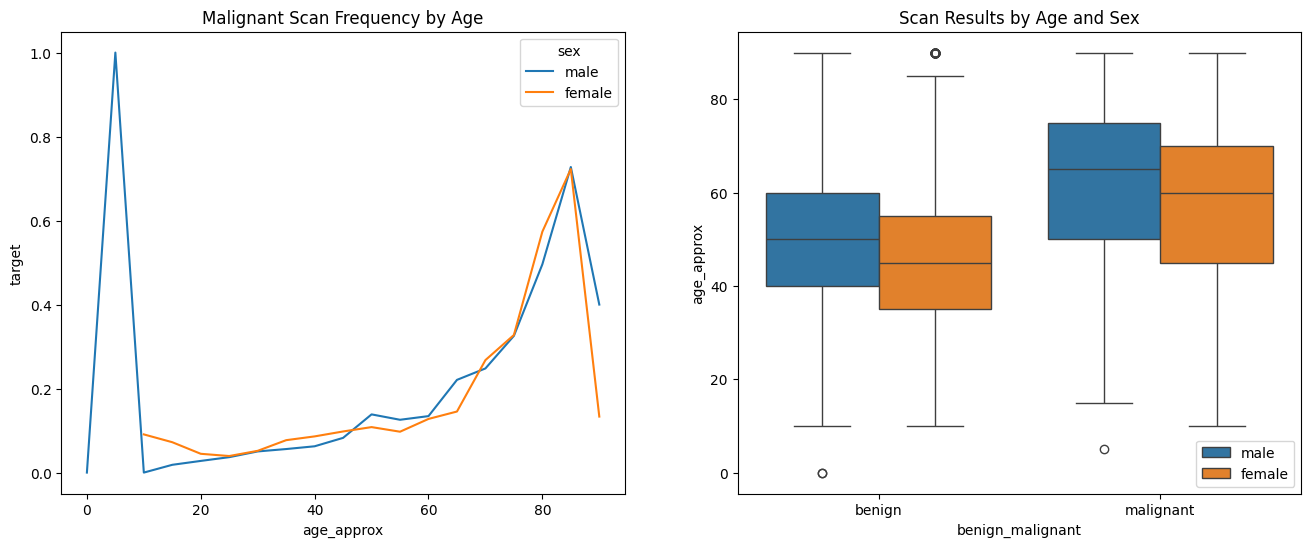

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age_approx',
             y='target',
             data=train_df,
             ax=ax[0],
             hue='sex',
             ci=None)
sns.boxplot(x='benign_malignant',
            y='age_approx',
            data=train_df,
            ax=ax[1],
            hue='sex')

plt.legend(loc='lower right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

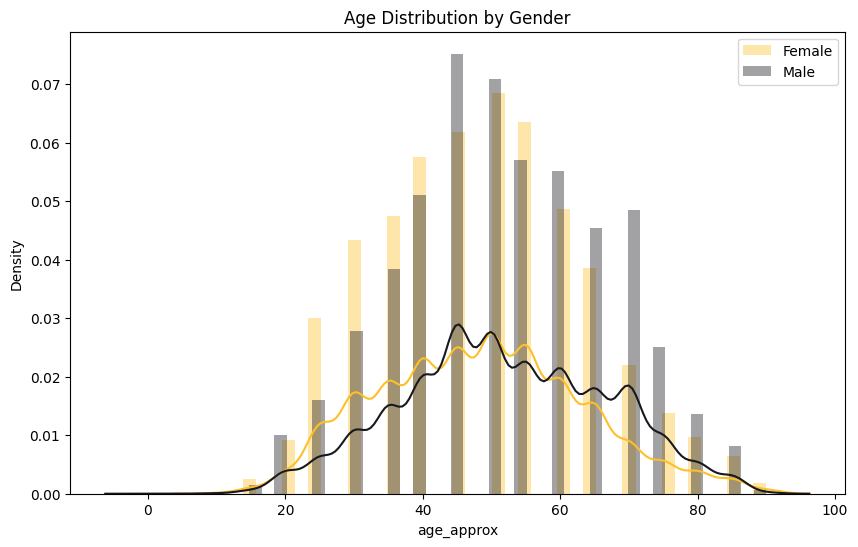

In [85]:
#Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets


fig, ax3 = plt.subplots(figsize=(10, 6))

# Set the title
ax3.set_title('Age Distribution by Gender')

# Plot
sns.distplot(train_df[train_df.sex == 'female'].age_approx,
             ax=ax3,
             label='Female',
             color='#fdc029')
sns.distplot(train_df[train_df.sex == 'male'].age_approx,
             ax=ax3,
             label='Male',
             color='#171820')
ax3.legend()

plt.show()

Diagnosis Distribution:

This part we can't use in our model but it's giving us some insights about this disease so we can inspect that too. You can see the details below:

In [87]:
diag = train_df['diagnosis'].value_counts()
fig = px.pie(diag,
             values=diag.values,
             names=diag.index,
             hole=0.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()